# Preprocessing

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time

# Part 1 of 4 - Discrete Fourier Transformation (DFT)

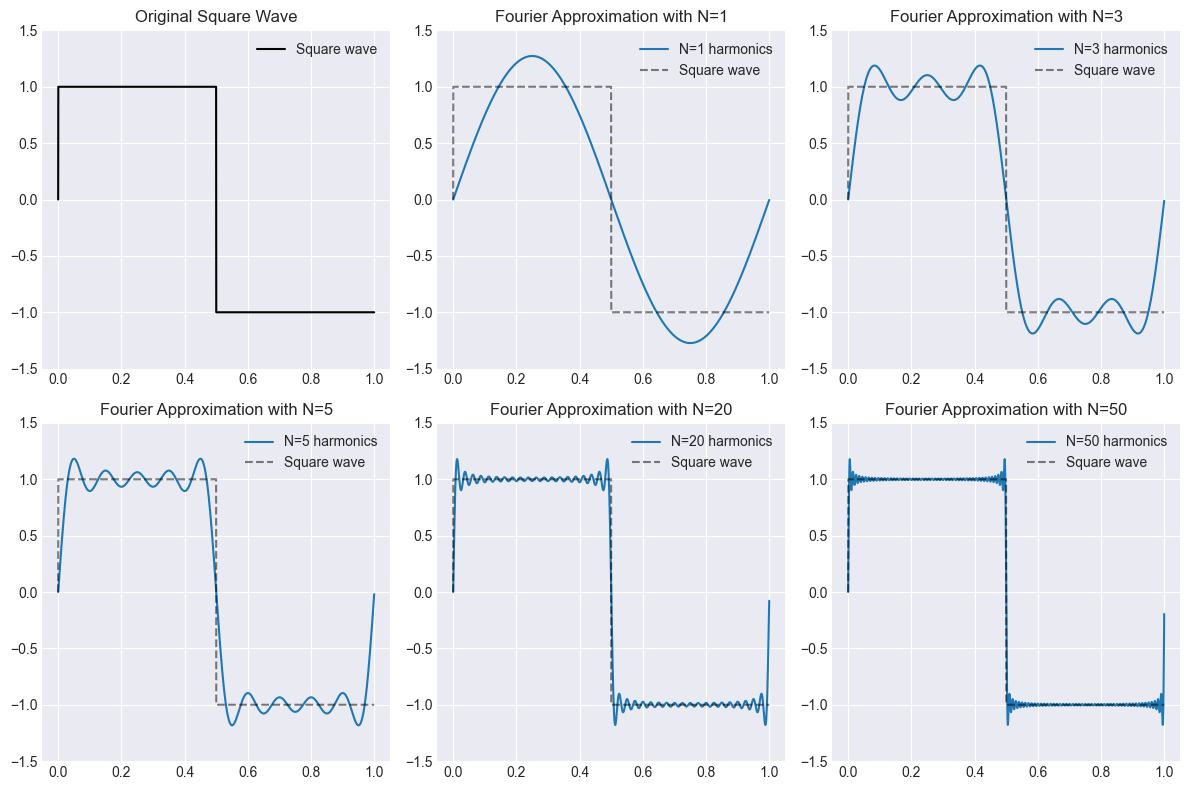

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

# Set parameters for the signal
N = 2048  # Number of sample points
T = 1.0   # Duration of the signal in seconds
f0 = 1    # Fundamental frequency of the square wave in Hz

# List of harmonic numbers used to construct the square wave
harmonics = [1, 3, 5, 20, 50]

# Define the square wave function
def square_wave(t):
    return torch.sign(torch.sin(2.0 * torch.pi * f0 * t))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
    result = torch.zeros_like(t)
    for k in range(N):
        # The Fourier series of a square wave contains only odd harmonics.
        n = 2 * k + 1
        # Add harmonics to reconstruct the square wave.
        result += torch.sin(2 * torch.pi * n * f0 * t) / n
    return (4 / torch.pi) * result

# Create the time vector
# torch.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
'''t = np.linspace(0.0, T, N, endpoint=False)'''
t = torch.linspace(0.0, T, N + 1)[:-1]

# Generate the original square wave
square = square_wave(t)

plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 65.471507 seconds
NumPy FFT Execution Time: 0.000223 seconds
FFT is approximately 293697.76 times faster.

Our DFT implementation is close to NumPy's FFT: False


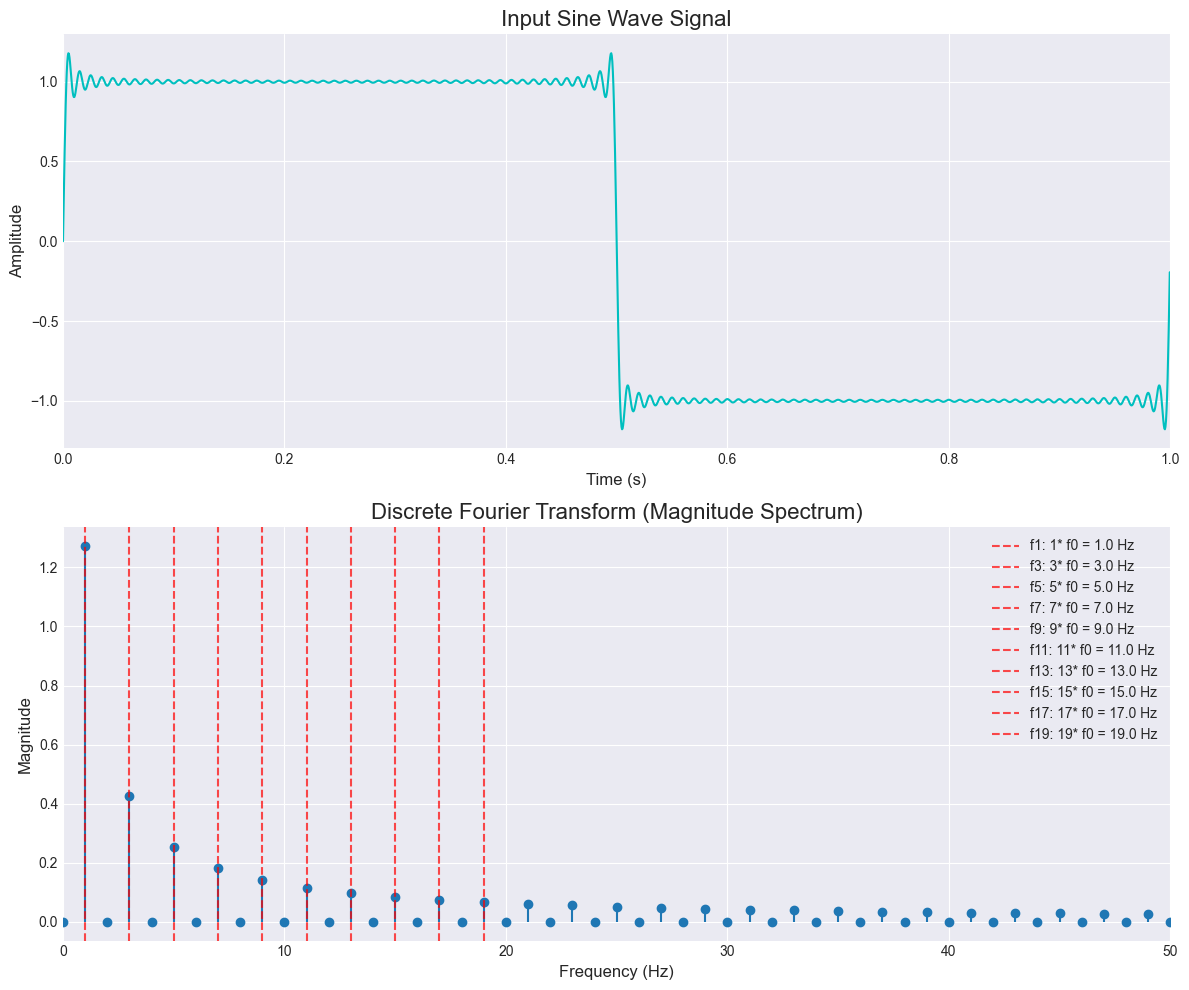

In [105]:
# 2. Apply the DFT and time the execution
def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).

    Args:
        x (torch.ndarray): The input signal, a 1D NumPy array.

    Returns:
        torch.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = torch.zeros(N, dtype=torch.complex128)

    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            '''angle = -2j * torch.pi * k * n / N'''
            '''X[k] += x[n] * np.exp(angle)'''
            angle = -2.0 * torch.pi * k * n / N
            complex_angle = torch.tensor(angle, dtype=torch.complex128) * 1j
            X[k] += x[n] * torch.exp(complex_angle)

    return X


# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = torch.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")

# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# torch.allclose is used for comparing floating-point arrays.
dft_result_float = dft_result.to(torch.complex64)
print(f"\nOur DFT implementation is close to NumPy's FFT: {torch.allclose(dft_result_float, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# torch.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = torch.fft.fftfreq(N, d=T/N)[:N//2]

# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * torch.abs(dft_result[0:N//2])

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
'''ax1.plot(t, signal, color='c')'''
ax1.plot(t.numpy(), signal.numpy(), color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0)  # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
'''ax2.stem(xf, magnitude, basefmt=" ")'''
ax2.stem(xf.numpy(), magnitude.numpy(), basefmt=" ")
ax2.set_title('Discrete Fourier Transform (Magnitude Spectrum)', fontsize=16)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50)  # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1:  # Only plot odd harmonics
        ax2.axvline(
            #xf[i], color='r', linestyle='--', alpha=0.7,
            xf[i].item(), color='r', linestyle='--', alpha=0.7,
            label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
        )

# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()


# Part 2 of 4 - Eigenfaces

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
(966, 150)
(322, 150)


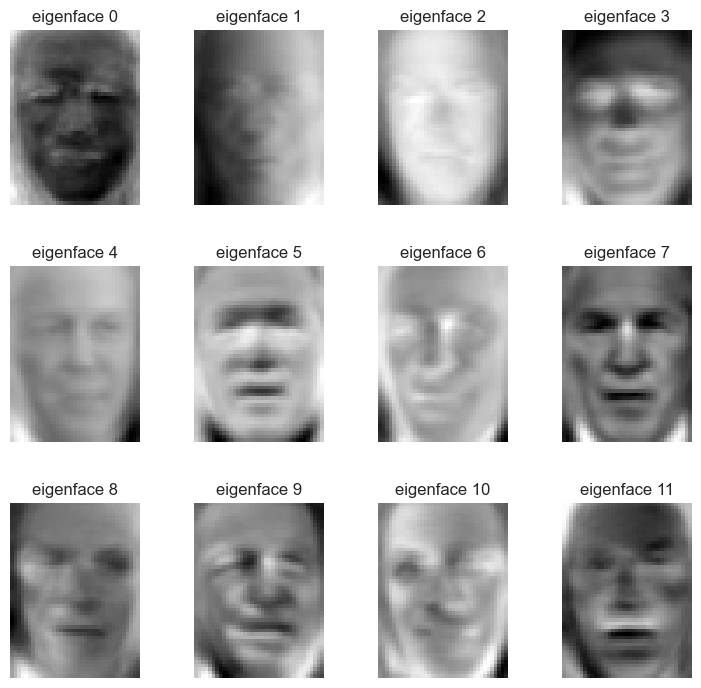

In [106]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

# Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

torch.Size([966])


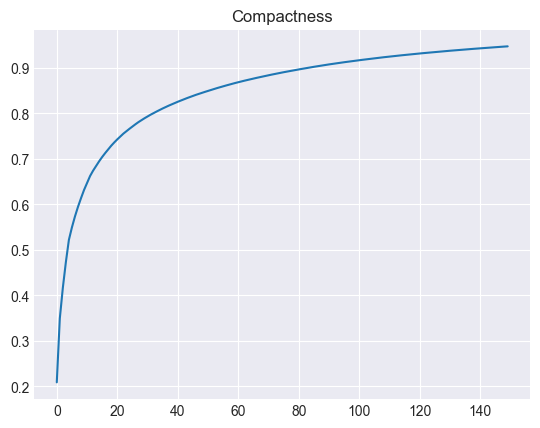

In [107]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
explained_variance_ratio_tensor = torch.from_numpy(explained_variance_ratio)
ratio_cumsum = torch.cumsum(explained_variance_ratio_tensor, dim=0)
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 3 3 3 3 3 4 3 3 4 1 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 3 3 6 1 3 4 3 5 3 4 1 3 6 6 3 3
 3 2 3 1 3 3 6 3 3 3 3 3 3 3 3 3 5 3 3 3 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 3 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 3 3 3 4 3 3 4 3 3 3 3 1 3 3 3 3
 4 1 1 3 1 3 3 3 6 1 3 3 6 5 5 3 3 3 5 1 3 3 1 3 3 1 5 3 3 3 3 5 3 3 3 3 3
 3 3 3 3 2 6 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 3 2 1 5 3 3 3 3 3 1 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 3 6 3 3 3 4 3 3 3 3 3 3 3 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 2 3 5 3 3 3
 3 5 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 5 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Part 3 of 4 - CNNs

## Task 3.1

In [109]:
# The following code could be used for data preprocessing if using pytorch
X = lfw_people.images
Y = lfw_people.target
# Verify the value range of X_train. No normalization is necessary in this case,
# as the input values already fall within the range of 0.0 to 1.0.
print("X_min:",X.min(),"X_train_max:", X.max())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]
print("X_train shape:", X_train.shape)

X_min: 0.0 X_train_max: 1.0
X_train shape: (966, 1, 50, 37)


## Task 3.2

In [110]:
# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if not torch.backends.mps.is_available():
    print("MPS not available, using CPU.")
    
# Hyper-parameters
num_epochs = 35
learning_rate = 0.1

Setup all the data regularisation through weak augmentation of images. Without this, the models will always overfit and give low (~80%) accuracy on the test set. Note the different regularisations pipelines for the training and test sets, though the initial pre-processing is the same.

In [112]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect')
])

transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

Load the standard dataset using PyTorch data pipelines.

In [113]:
trainset = torchvision.datasets.CIFAR10(
    root='cifar10', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True) # num_workers=6

testset = torchvision.datasets.CIFAR10(
    root='cifar10', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False) # num_workers=6

100%|██████████| 170498071/170498071 [02:01<00:00, 1408268.95it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


Now setup the ResNet model from scratch. You could use the pre-built model from within PyTorch, but this is more instructive from our own version. Start with basic ResNet block.

In [114]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

Then construct the general ResNet network that is capable of having its various parameters/depth defined to create different versions. Then define the actual ResNet that is needed for CIFAR10.

In [117]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
        return ResNet(BasicBlock, [2, 2, 2, 2])

Declare the actual model and move it to the GPU. We print the model info to check.

In [124]:

model = ResNet18()
model = model.to(device)

if device.type == 'mps':
    print(torch.device("mps"))
    
# Model info
print("Model No. of Parameters:", sum([param.nelement() for param in model.parameters()]))
print(model)

mps
Model No. of Parameters: 11173962
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2

Define the optimisation parameters, losses etc. We will use a piece-wise linear learning rate schedule to adjust the learning rate right up to the pre-defined number of epochs for quickest training.

In [126]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# Piecewise Linear Schedule
total_step = len(train_loader)
sched_linear_1 = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.005, max_lr=learning_rate, step_size_up=15, step_size_down=15, mode='triangular', verbose=False)
sched_linear_3 = torch.optim.lr_scheduler.LinearLR(optimiser, start_factor=0.005/learning_rate, end_factor=0.005/5, verbose=False)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimiser, schedulers=[sched_linear_1, sched_linear_3], milestones=[30])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  "https://github.com/pytorch/pytorch/issues/new/choose."


Train the model with a simple training loop and report loss progress periodically.

In [127]:
# Train the model
model.train()
print("> Training")
start = time.time() # Time generation
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forwards pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.5f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    scheduler.step()
end = time.time()
elapsed = end - start
print("Training took " + str(elapsed) + " secs or " + str(elapsed/60) + " mins in total")

> Training
Epoch [1/35], Step [100/391] Loss: 1.40042
Epoch [1/35], Step [200/391] Loss: 1.45932
Epoch [1/35], Step [300/391] Loss: 1.28375
Epoch [2/35], Step [100/391] Loss: 0.95317
Epoch [2/35], Step [200/391] Loss: 0.92711
Epoch [2/35], Step [300/391] Loss: 0.81131
Epoch [3/35], Step [100/391] Loss: 0.99458
Epoch [3/35], Step [200/391] Loss: 0.88259
Epoch [3/35], Step [300/391] Loss: 0.77692
Epoch [4/35], Step [100/391] Loss: 0.61017
Epoch [4/35], Step [200/391] Loss: 0.73894
Epoch [4/35], Step [300/391] Loss: 0.65922
Epoch [5/35], Step [100/391] Loss: 0.45991
Epoch [5/35], Step [200/391] Loss: 0.46729
Epoch [5/35], Step [300/391] Loss: 0.60166
Epoch [6/35], Step [100/391] Loss: 0.60387
Epoch [6/35], Step [200/391] Loss: 0.38329
Epoch [6/35], Step [300/391] Loss: 0.63273
Epoch [7/35], Step [100/391] Loss: 0.52768
Epoch [7/35], Step [200/391] Loss: 0.40544
Epoch [7/35], Step [300/391] Loss: 0.39043
Epoch [8/35], Step [100/391] Loss: 0.52125
Epoch [8/35], Step [200/391] Loss: 0.42662


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  UserWarning,


Epoch [31/35], Step [100/391] Loss: 0.03681
Epoch [31/35], Step [200/391] Loss: 0.03555
Epoch [31/35], Step [300/391] Loss: 0.03982
Epoch [32/35], Step [100/391] Loss: 0.02840
Epoch [32/35], Step [200/391] Loss: 0.01680
Epoch [32/35], Step [300/391] Loss: 0.00868
Epoch [33/35], Step [100/391] Loss: 0.03719
Epoch [33/35], Step [200/391] Loss: 0.04480
Epoch [33/35], Step [300/391] Loss: 0.00788
Epoch [34/35], Step [100/391] Loss: 0.02867
Epoch [34/35], Step [200/391] Loss: 0.07479
Epoch [34/35], Step [300/391] Loss: 0.04392
Epoch [35/35], Step [100/391] Loss: 0.01571
Epoch [35/35], Step [200/391] Loss: 0.04887
Epoch [35/35], Step [300/391] Loss: 0.01788
Training took 3015.9490518569946 secs or 50.26581753094991 mins in total


Test the model through model inference and report the total testing accuracy.

In [128]:
# Test the model
print("> Testing")
start = time.time() # Time generation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        print('Test Accuracy: {} %'.format(100 * correct/total))
        end = time.time()
        elapsed = end - start
        print("Testing took " + str(elapsed) + " secs or " + str(elapsed/60) + " mins in total")

> Testing
Test Accuracy: 93.75 %
Testing took 0.42189502716064453 secs or 0.007031583786010742 mins in total
Test Accuracy: 94.53125 %
Testing took 0.4947810173034668 secs or 0.008246350288391113 mins in total
Test Accuracy: 95.3125 %
Testing took 0.5589230060577393 secs or 0.009315383434295655 mins in total
Test Accuracy: 95.3125 %
Testing took 0.6219537258148193 secs or 0.010365895430246989 mins in total
Test Accuracy: 95.3125 %
Testing took 0.6953399181365967 secs or 0.011588998635609945 mins in total
Test Accuracy: 94.79166666666667 %
Testing took 0.7590930461883545 secs or 0.012651550769805908 mins in total
Test Accuracy: 93.97321428571429 %
Testing took 0.8226907253265381 secs or 0.013711512088775635 mins in total
Test Accuracy: 93.65234375 %
Testing took 0.8876807689666748 secs or 0.014794679482777913 mins in total
Test Accuracy: 93.40277777777777 %
Testing took 0.9535360336303711 secs or 0.01589226722717285 mins in total
Test Accuracy: 93.4375 %
Testing took 1.026728868484497 s

# Part 4 of 4 - Recognition

In [ ]:
# Data loading and preprocessing for OASIS dataset
import os
import glob
from PIL import Image
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.init as init

# Dataset paths
OASIS_PATH = "/Users/shubhgupta/Library/CloudStorage/GoogleDrive-shubhgupta2510@gmail.com/My Drive/Shubh Gupta/University/YEAR 5/SEM 2/COMP3710/Lab Demos/OASIS"
TRAIN_IMAGES_PATH = os.path.join(OASIS_PATH, "keras_png_slices_train")
TRAIN_MASKS_PATH = os.path.join(OASIS_PATH, "keras_png_slices_seg_train")
TEST_IMAGES_PATH = os.path.join(OASIS_PATH, "keras_png_slices_test")
TEST_MASKS_PATH = os.path.join(OASIS_PATH, "keras_png_slices_seg_test")

print("Data paths configured successfully!")
print(f"Train images path exists: {os.path.exists(TRAIN_IMAGES_PATH)}")
print(f"Train masks path exists: {os.path.exists(TRAIN_MASKS_PATH)}")